In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
import numpy as np

sales_url = r"C:\Users\fomin\GitHub_projects\Analytics\Zara_sales\zara_sales.csv"
sales = pd.read_csv(sales_url, sep = ';')

sales.head()

# Импортируем нужные библиотеки, подгружаем файл с данными и смотрим его

,Product ID,Product Position,Promotion,Product Category,Seasonal,Sales Volume,brand,url,sku,name,description,price,currency,scraped_at,terms,section
0,185102,Aisle,No,Clothing,No,2823,Zara,https://www.zara.com/us/en/basic-puffer-jacket...,272145190-250-2,BASIC PUFFER JACKET,Puffer jacket made of tear-resistant ripstop f...,19.99,USD,2024-02-19T08:50:05.654618,jackets,MAN
1,188771,Aisle,No,Clothing,No,654,Zara,https://www.zara.com/us/en/tuxedo-jacket-p0889...,324052738-800-46,TUXEDO JACKET,Straight fit blazer. Pointed lapel collar and ...,169.00,USD,2024-02-19T08:50:06.590930,jackets,MAN
2,180176,End-cap,Yes,Clothing,Yes,2220,Zara,https://www.zara.com/us/en/slim-fit-suit-jacke...,335342680-800-44,SLIM FIT SUIT JACKET,Slim fit jacket. Notched lapel collar. Long sl...,129.00,USD,2024-02-19T08:50:07.301419,jackets,MAN
3,112917,Aisle,Yes,Clothing,Yes,1568,Zara,https://www.zara.com/us/en/stretch-suit-jacket...,328303236-420-44,STRETCH SUIT JACKET,Slim fit jacket made of viscose blend fabric. ...,129.00,USD,2024-02-19T08:50:07.882922,jackets,MAN
4,192936,End-cap,No,Clothing,Yes,2942,Zara,https://www.zara.com/us/en/double-faced-jacket...,312368260-800-2,DOUBLE FACED JACKET,Jacket made of faux leather faux shearling wit...,139.00,USD,2024-02-19T08:50:08.453847,jackets,MAN


In [2]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

In [3]:
sales.columns = sales.columns.str.lower().str.replace(' ', '_')

# Привожу к удобному для работы виду названия колонок 

In [4]:
sales.shape

(252, 16)

In [5]:
sales['revenue_by_item'] = sales.sales_volume * sales.price

# Ввожу новый столбец, который описывает выручку с айтема - перемножив количество проданного товара на его цену

In [6]:
sales.duplicated().sum()

# Проверка на дубликаты

0

In [7]:
sales.isnull().sum()

# Проверка на нулевые значения

product_id          0
product_position    0
promotion           0
product_category    0
seasonal            0
sales_volume        0
brand               0
url                 0
sku                 0
name                1
description         2
price               0
currency            0
scraped_at          0
terms               0
section             0
revenue_by_item     0
dtype: int64

In [8]:
is_null_df = sales.isnull()
row_with_null = is_null_df.any(axis=1)
rows_with_null = sales[row_with_null]
rows_with_null

# поиск строк, где есть хотя бы одно нулевое значение
# можно дропнуть эти строки из датафрейма, учтя выручку с товаров в них

,product_id,product_position,promotion,product_category,seasonal,sales_volume,brand,url,sku,name,description,price,currency,scraped_at,terms,section,revenue_by_item
60,151925,End-cap,Yes,Clothing,Yes,2179,Zara,https://www.zara.com/us/en/vintage-effect-leat...,320774184-800-97,VINTAGE EFFECT LEATHER BOMBER JACKET,NaN,299.0,USD,2024-02-19T08:50:43.543555,jackets,MAN,651521.0
72,173576,End-cap,Yes,Clothing,No,1838,Zara,https://www.zara.com/us/en/-p04310461.html,336378923-700-2,NaN,NaN,129.0,USD,2024-02-19T08:50:54.476057,jackets,MAN,237102.0


In [9]:
np.round(100 - (sales.revenue_by_item.sum() - rows_with_null.revenue_by_item.sum())/sales.revenue_by_item.sum()*100, 2)

# Считаем % выручки, который уйдет при дропе строчек с нулями

2.28

In [10]:
sales = sales.dropna()

# Дропаем нулевые значения

In [11]:
sales.product_category.unique()

# категория товаров лишь одна, ее нет смысла анализировать

array(['Clothing'], dtype=object)

In [12]:
# Рассмотрим данные в отношении выручки с товаров

In [13]:
sales[['product_id', 'revenue_by_item']].sort_values('revenue_by_item').head()

# Способо№1: Считаем выручку по id продукта в списке продаж

,product_id,revenue_by_item
162,136738,4330.58
203,171776,21888.15
189,185307,21916.57
234,185774,22888.55
210,142257,23482.00


In [14]:
sales.groupby('product_id', as_index=False).revenue_by_item.sum().sort_values('revenue_by_item').head()

# Способо№2: Считаем выручку по id продукта в списке продаж, надо разобраться какой способ корректнее
# - вспомнить, что такое product_id на kaggle

,product_id,revenue_by_item
84,136738,4330.58
174,171776,21888.15
212,185307,21916.57
213,185774,22888.55
101,142257,23482.00


In [15]:
sales.name.nunique() - sales.groupby('name').filter(lambda x: len(x) == 1).shape[0]

# Получается 40 уникальных name повторяются в sales

40

In [16]:
nunique_name = sales.groupby('name', as_index=False).agg({'revenue_by_item':'count'}).sort_values('revenue_by_item') \
    .rename(columns={'revenue_by_item':'counts_in_df'})

nunique_name.loc[nunique_name.counts_in_df > 1].head()

# Датафрейм уникальных значений name, которые повторяются 2 или более раз 

,name,counts_in_df
162,SUIT JACKET,2
185,WOOL BLEND JACKET,2
160,SUEDE SNEAKERS,2
167,TECHNICAL PADDED JACKET,2
0,100% FEATHER FILL PUFFER JACKET,2


In [17]:
sales[sales.groupby('name')['name'].transform('size') > 1].sort_values('name').head()

# Все повторящиеся по name строки. Пока просто так сделал, мб потом придумаю что с этим можно еще сделать

,product_id,product_position,promotion,product_category,seasonal,sales_volume,brand,url,sku,name,description,price,currency,scraped_at,terms,section,revenue_by_item
9,137121,Aisle,No,Clothing,Yes,656,Zara,https://www.zara.com/us/en/100-feather-fill-pu...,312372602-800-2,100% FEATHER FILL PUFFER JACKET,Puffer jacket made of shiny finish technical f...,169.0,USD,2024-02-19T08:50:11.380061,jackets,MAN,110864.0
97,120228,End-cap,No,Clothing,No,2347,Zara,https://www.zara.com/us/en/100-feather-fill-pu...,327116625-505-2,100% FEATHER FILL PUFFER JACKET,Puffer vest made of technical fabric. Fill is ...,89.9,USD,2024-02-19T08:51:09.075286,jackets,MAN,210995.3
200,141547,End-cap,No,Clothing,No,1426,Zara,https://www.zara.com/us/en/baggy-fit-jeans-p06...,315738965-802-34,BAGGY FIT JEANS,Baggy fit jeans. Five pockets. Washed effect. ...,69.9,USD,2024-02-19T08:54:39.496146,jeans,MAN,99677.4
199,198283,End-cap,Yes,Clothing,Yes,1558,Zara,https://www.zara.com/us/en/baggy-fit-jeans-p08...,315836999-406-34,BAGGY FIT JEANS,Baggy fit jeans. Five pockets. Washed effect. ...,69.9,USD,2024-02-19T08:54:39.017964,jeans,MAN,108904.2
92,146839,Aisle,No,Clothing,No,1525,Zara,https://www.zara.com/us/en/bomber-jacket-p0534...,321496813-710-2,BOMBER JACKET,Jacket with padded interior. Rib elastic colla...,109.0,USD,2024-02-19T08:51:06.241653,jackets,MAN,166225.0


In [43]:
sales \
    .groupby('name', as_index=False) \
    .agg({'revenue_by_item':'sum'}) \
    .sort_values('revenue_by_item', ascending = False)

# Считаем выручку по name продукта в списке продаж, находим топ продаж

,name,revenue_by_item
39,CONTRASTING PATCHES BOMBER JACKET,889308.00
163,SUIT JACKET IN 100% LINEN,816675.00
57,FAUX LEATHER BOMBER JACKET,798852.60
118,PLAID OVERSHIRT,695369.00
136,RIB COLLAR JACKET,685883.00
...,...,...
134,RETRO SNEAKERS,24885.09
21,BASIC SLIM FIT T-SHIRT,23482.00
15,BASIC 100% WOOL SWEATER,21916.57
51,DENIM SHIRT,21888.15


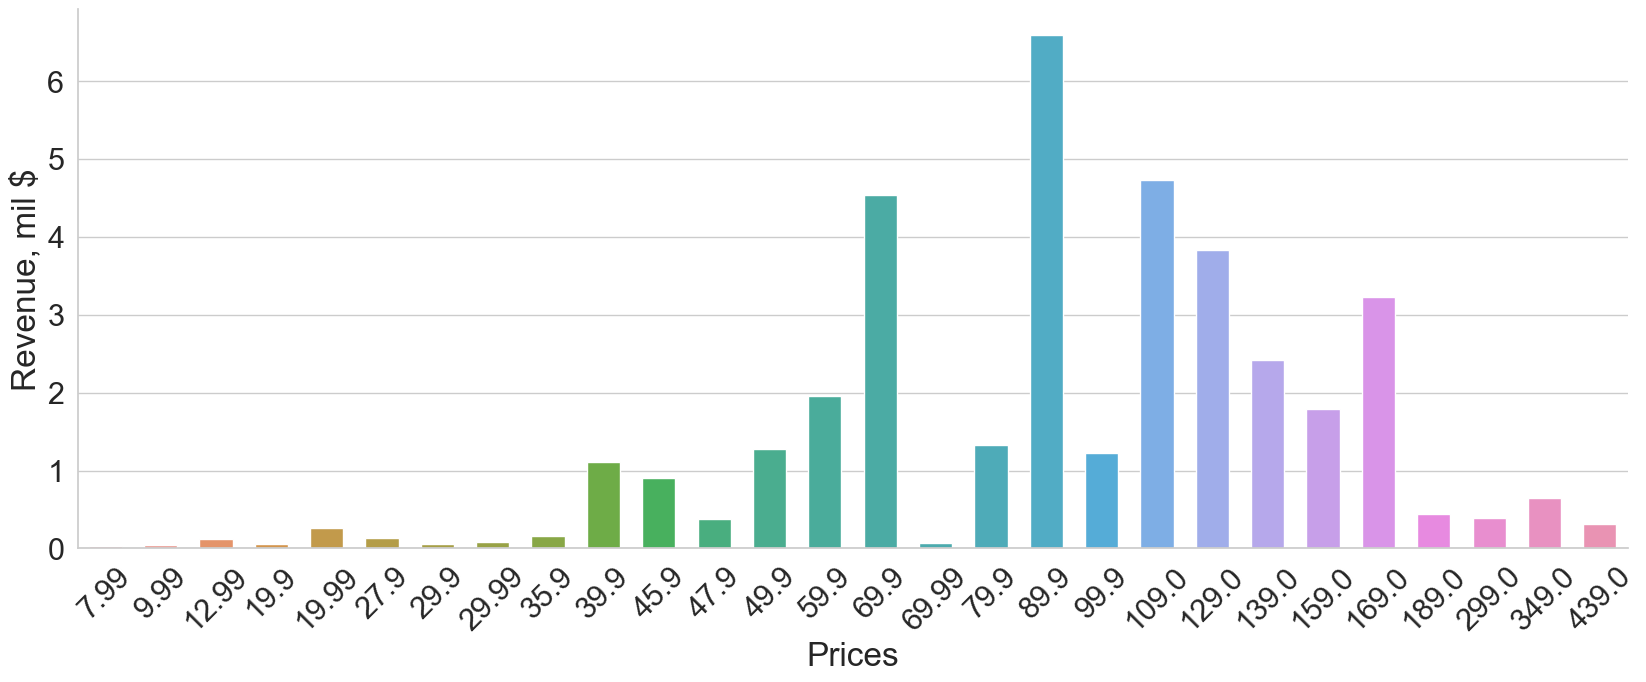

In [19]:
rev_by_price_df = sales \
    .groupby('price', as_index = False) \
    .revenue_by_item.sum()

# Создаем датафрейм выручки, полученной в зависимости от цены айтема

plt.pyplot.xticks(rotation=45)
ax0 = sns.barplot(x = rev_by_price_df.price, y = rev_by_price_df.revenue_by_item/1000000, width = 0.6)
ax0.set(ylabel='Revenue, mil $', xlabel='Prices')
sns.despine()

# Получаем распределение выручки в зависимости от цены вещи - смотрим, какие ценовые сегменты приносят более всего денег


# кластеризуй эти данные по ценам

[Text(0.5, 0, 'Revenue, mil $')]

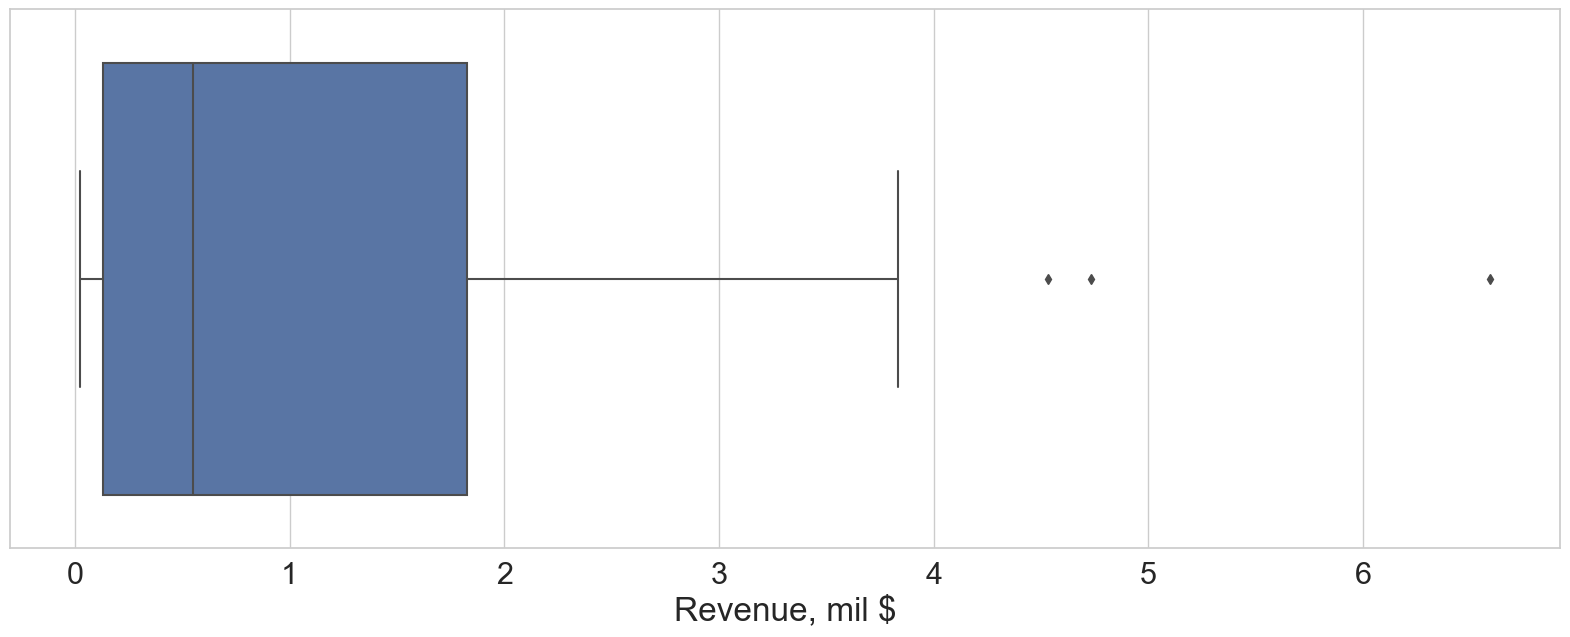

In [20]:
ax01 = sns.boxplot(x = rev_by_price_df.revenue_by_item/1000000)
ax01.set(xlabel='Revenue, mil $')

In [21]:
rev_by_price_df[rev_by_price_df.revenue_by_item > np.percentile(rev_by_price_df.revenue_by_item, 50)] \
    .sort_values('revenue_by_item')

,price,revenue_by_item
26,349.0,649140.0
10,45.9,898446.6
9,39.9,1103993.1
18,99.9,1226472.3
12,49.9,1275044.8
16,79.9,1324342.5
22,159.0,1786206.0
13,59.9,1952260.8
21,139.0,2413040.0
23,169.0,3233815.0


[Text(0.5, 0, 'Prices')]

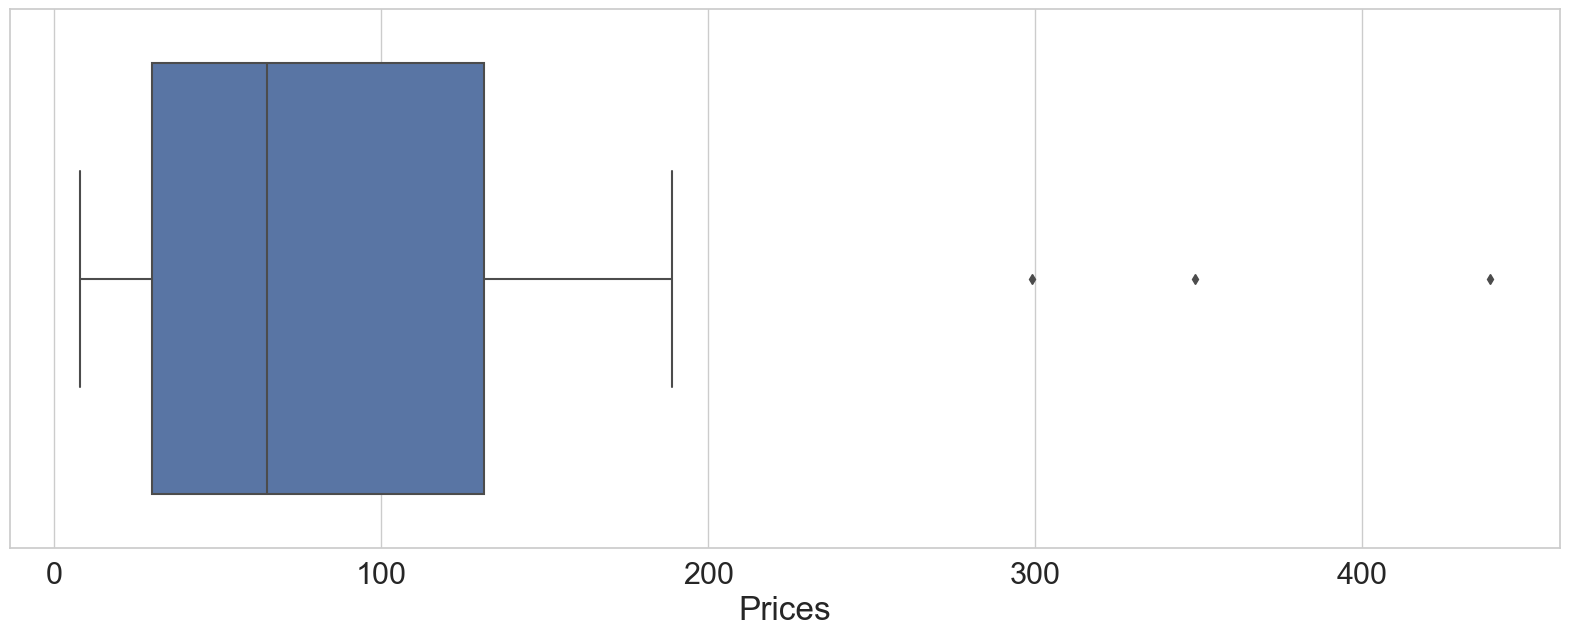

In [22]:
ax02 = sns.boxplot(x = rev_by_price_df.price)
ax02.set(xlabel='Prices')

In [23]:
# Теперь рассмотрим данные в разрезе мужского и женского отдела продаж

<Axes: xlabel='section', ylabel='count'>

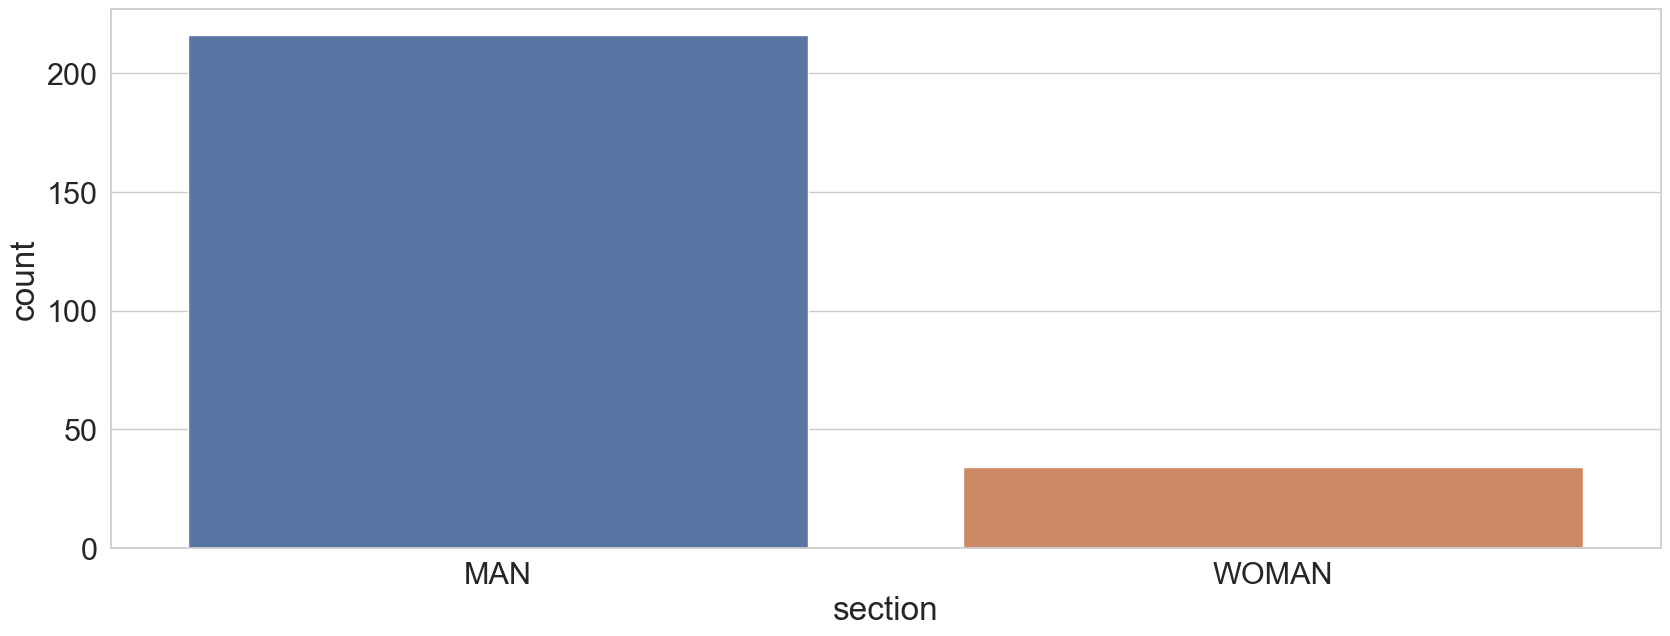

In [24]:
sns.countplot(sales, x = "section")

# Количество покупок в мужском и женском отделах

[Text(0.5, 0, 'Gender'), Text(0, 0.5, 'Revenue, mil $')]

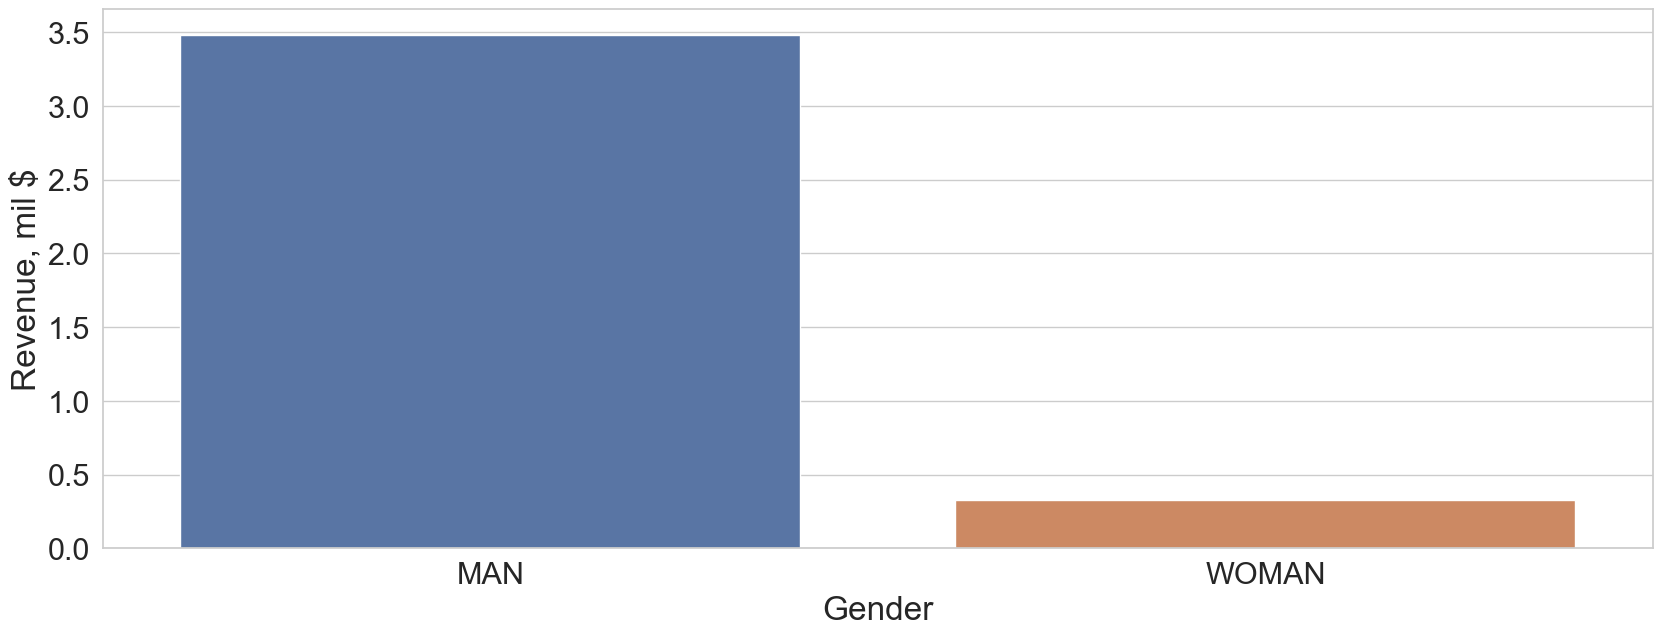

In [25]:
rev_by_gender_df = sales \
    .groupby('section', as_index=False) \
    .revenue_by_item.sum() \
    .rename(columns={'revenue_by_item':'revenue'})

rev_by_gender_df['revenue_share'] = np.round(rev_by_gender_df.revenue / rev_by_gender_df.revenue.sum() * 100,1)

# Создаем датафрейм с выручкой по гендерам rev_by_gender_df
# и отдельно столбец с долей выручки каждого отдела продаж (М и Ж) revenue_share

ax1 = sns.barplot(x=rev_by_gender_df.section, y=rev_by_gender_df.revenue /10000000)
ax1.set(xlabel='Gender', ylabel='Revenue, mil $')
# Выручка, принесенная мужским и женским отделами

In [26]:
count_purch_by_gender_df = sales \
    .groupby('section', as_index=False) \
    .sales_volume.sum() \
    .rename(columns={'sales_volume':'number_of_purchases'})

count_purch_by_gender_df['num_of_purch_share'] = np.round(count_purch_by_gender_df.number_of_purchases / count_purch_by_gender_df.number_of_purchases.sum() * 100,1)
# Создаем датафрейм с количеством покупок по гендерной секции count_purch_by_gender_df
# и отдельно столбец с долей количества покупок каждого отдела продаж (М и Ж) num_of_purch_share

gender_df = rev_by_gender_df.merge(count_purch_by_gender_df)
gender_df['mean_revenue_by_gend'] = np.round(gender_df.revenue / gender_df.number_of_purchases, 2)
gender_df['mean_rev_by_gen_share'] = np.round(gender_df.mean_revenue_by_gend / gender_df.mean_revenue_by_gend.sum() * 100, 2)

gender_df

# Создаем столбец mean_revenue_by_gend, в котором посчитали среднюю выручку с одной покупки для секций мужчин и женщин
# Также создали столбец mean_rev_by_gen_share, в котором посчитали долю секций в средней выручке

,section,revenue,revenue_share,number_of_purchases,num_of_purch_share,mean_revenue_by_gend,mean_rev_by_gen_share
0,MAN,34824040.03,91.4,392182,86.1,88.80,63.21
1,WOMAN,3275813.45,8.6,63374,13.9,51.69,36.79


In [27]:
# Все относительные показатели, такие, как доля выручки на гендерный отдел, revenue_share,
# доля количества покупок на гендерный отдел, num_of_purch_share,
# и доля в среднем чеке по гендерному отделу, mean_rev_by_gen_share,
# говорят о том, что основной целевой аудиторией магазина являются мужчины, 
# потому что их средняя покупка приносит намного больше денег, в среднем они намного чаще покупают, и их просто больше 

# На основе описанных тезисов можно сделать вывод, что в моменте мужская целевая аудитория сильно важнее для магазина

In [28]:
# Рассмотрим теперь данные по категории товаров - колонке terms

<Axes: xlabel='terms', ylabel='Count'>

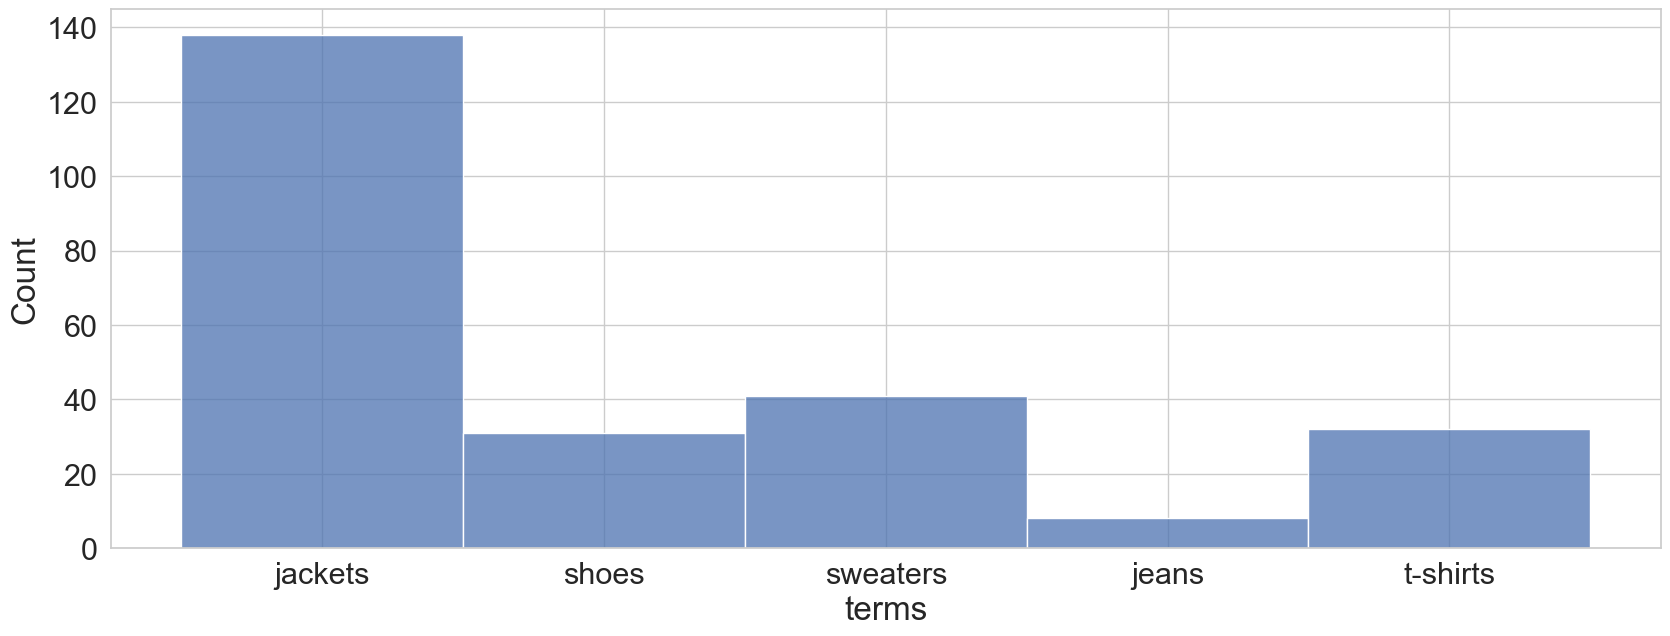

In [29]:
sns.histplot(sales.terms)

# Построим распределение количества товаров по их типу

[Text(0, 0.5, 'Revenue, mil $'), Text(0.5, 0, 'Type')]

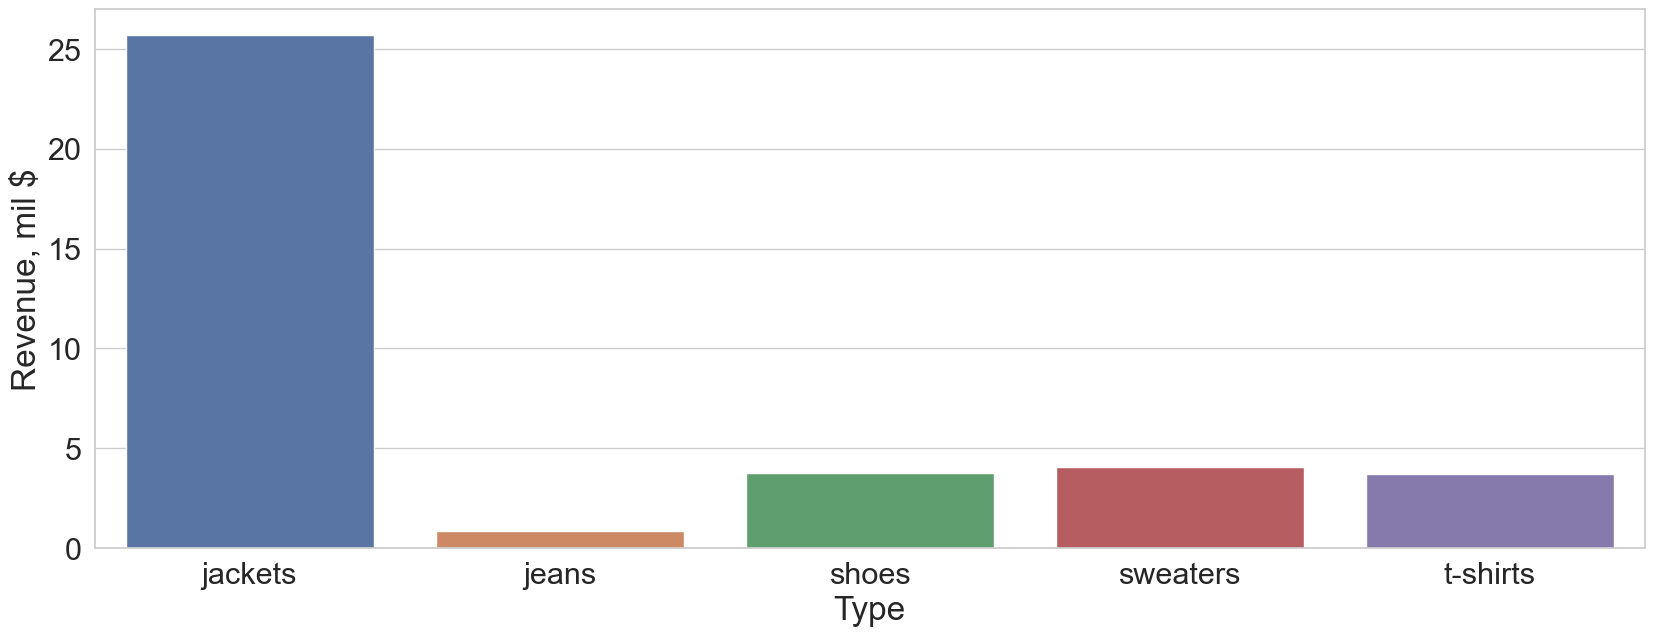

In [30]:
ax2_0 = sns.barplot(x = sales \
                      .groupby('terms', as_index=False) \
                      .revenue_by_item.sum() \
                      .terms,
                  y = sales \
                      .groupby('terms', as_index=False) \
                      .revenue_by_item.sum() \
                      .revenue_by_item / 1000000)

ax2_0.set(ylabel = 'Revenue, mil $', xlabel = 'Type')

# Распределение выручки по типу товаров. Очевидный лидер - jackets. Попробуем разобраться почему это так

In [31]:
sales.terms.value_counts()

# Здесь посчитано количество уникальных позиций по каждому типу товаров. Лидер среди ассортимента - jackets

jackets     138
sweaters     41
t-shirts     32
shoes        31
jeans         8
Name: terms, dtype: int64

[Text(0.5, 0, 'Revenue, mil $'), Text(0, 0.5, 'Type')]

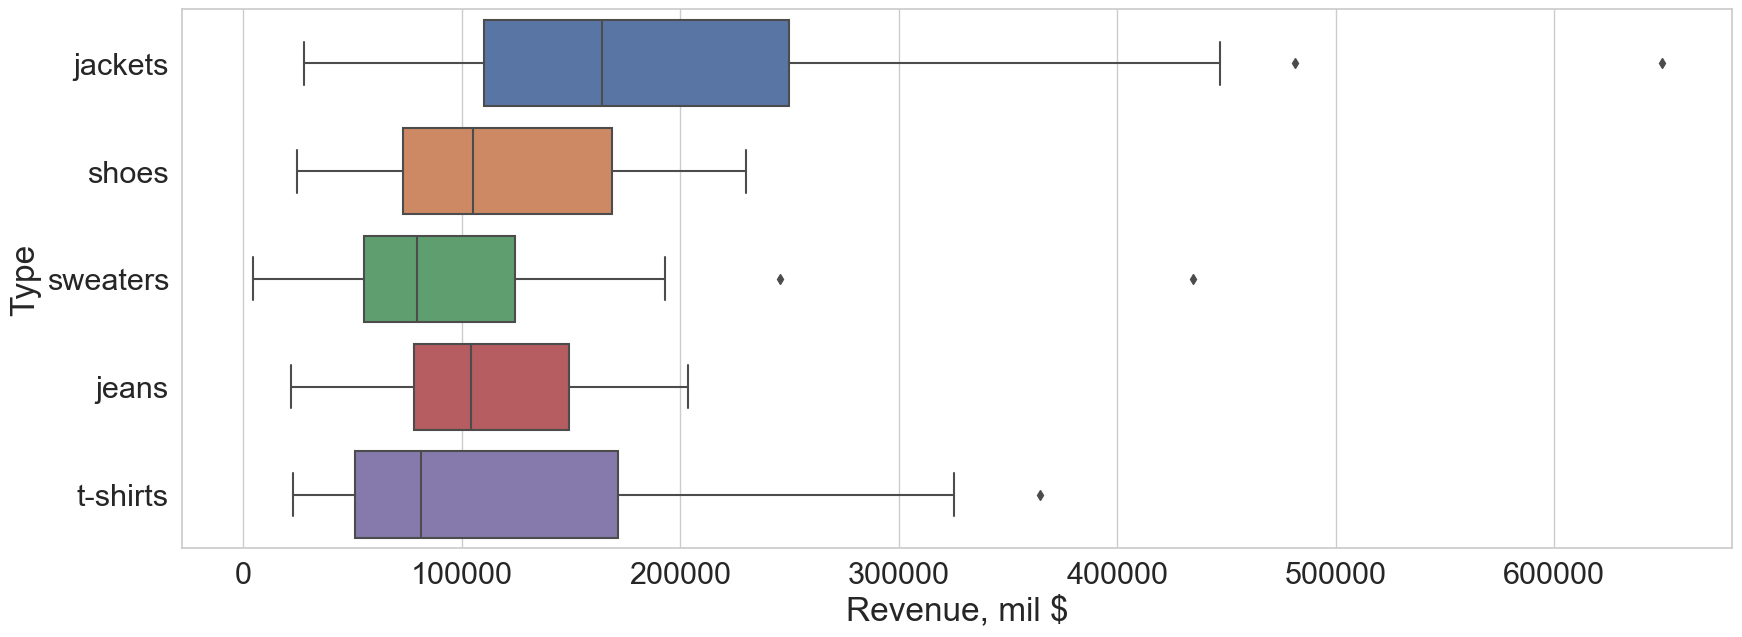

In [32]:
ax2_1 = sns.boxplot(data = sales, x='revenue_by_item', y = 'terms')

ax2_1.set(xlabel = 'Revenue, mil $', ylabel = 'Type')

# Построим боксплот для выручки, приносимой разными типами товаров. Видно, что jackets имеют больше как медианное значение,
# так и межквартильный размах, и экстремумы, и более значительные выбросы. 

[Text(0.5, 0, 'Sales volume'), Text(0, 0.5, 'Type')]

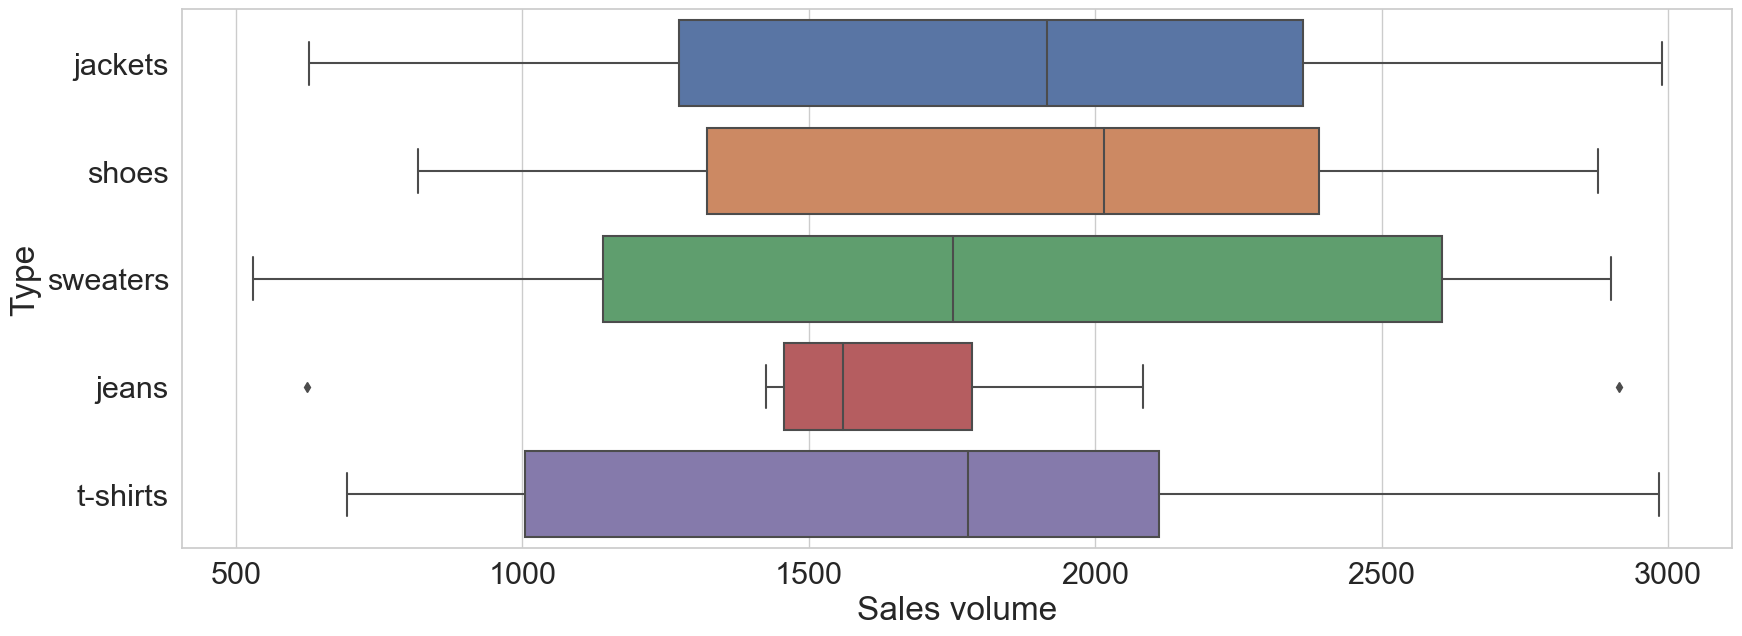

In [33]:
ax2_3 = sns.boxplot(data = sales, x='sales_volume', y = 'terms')

ax2_3.set(xlabel = 'Sales volume', ylabel = 'Type')\

# Здесь приведен боксплот количества проданного товара в зависимости от его типа
# Видно, что люди покупают примерно одинаково все типы, кроме jeans - вероятно людям одинаково нравятся все представленные
# товары внутри этой группы

[Text(0.5, 0, 'Prices'), Text(0, 0.5, 'Type')]

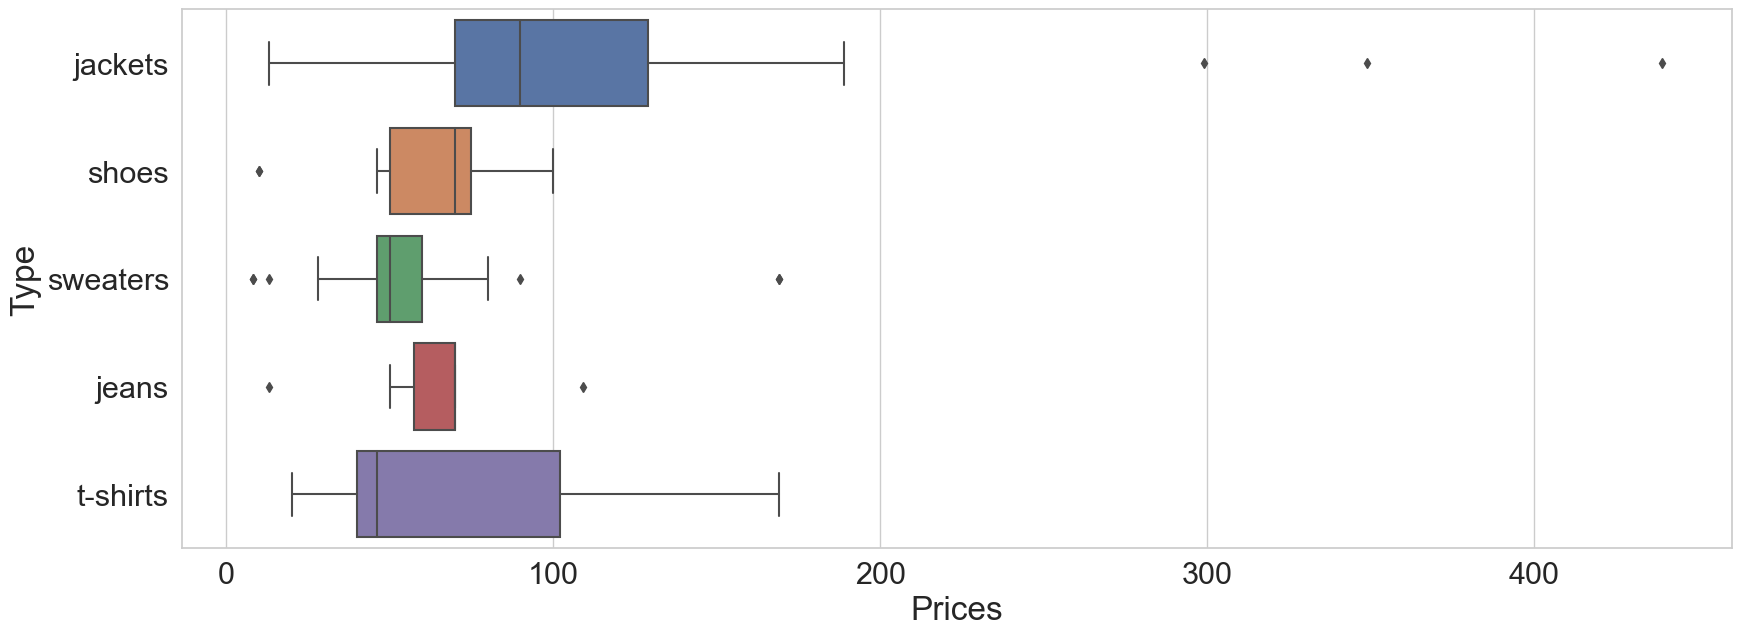

In [34]:
ax2_4 = sns.boxplot(data = sales, x = 'price', y = 'terms')

ax2_4.set(xlabel = 'Prices', ylabel = 'Type')

# В среднем наибольшие цены встречаются чаще всего в категории jackets

In [35]:
# Теперь посмотрим на данные в отношении товаров, которые участвуют в проушене (столбец promotion)

In [36]:
revenue_with_prom = sales \
    .query('promotion == "Yes"') \
    .revenue_by_item.sum() 
revenue_without_prom = sales \
    .query('promotion == "No"') \
    .revenue_by_item.sum()

np.round((revenue_with_prom - revenue_without_prom) / revenue_with_prom * 100, 2)

# Выручка с товаров, участвующих в промоушне, превышает выручку с товаров вне промоушна на 0.58%. 
# Имеет смысл сравнить полученную прибыль с этой дельты выручки с затратами на промоушн,
# чтобы определить эффективность настоящей программы промоушна
# Однако в рамках датасета, который используется в этом проекте, таких данных нет

0.58

In [44]:
# Следует также оценить вклад сезонности товаров на продажи (столбец seasonal)

In [59]:
revenue_with_season = sales.groupby('seasonal', as_index=False).revenue_by_item.sum()

rev_season_diff = np.round(revenue_with_season \
          .query('seasonal == "Yes"') \
          .revenue_by_item.sum() - revenue_with_season.query('seasonal == "No"').revenue_by_item.sum(),2)
rev_season_diff

# Выручка с сезонных товаров превышает выручку с несезонных на 261281.84

261281.84

In [58]:
np.round(rev_season_diff /  revenue_with_season \
          .query('seasonal == "Yes"') \
          .revenue_by_item.sum() * 100,2)

# Выручка с сезонных товаров превышает выручку с несезонных на 1.36%.

1.36

In [37]:
# Обратим внимание на данные по товарам относительно их местонахождения в помещении магазина (столбец product_position)
# Есть 3 варианта: Aisle (проход, коридор), end-cap (конец прохода - aisle), front of store (лицевая часть магазина)

[Text(0.5, 0, 'Revenue, mil $'), Text(0, 0.5, 'Product position')]

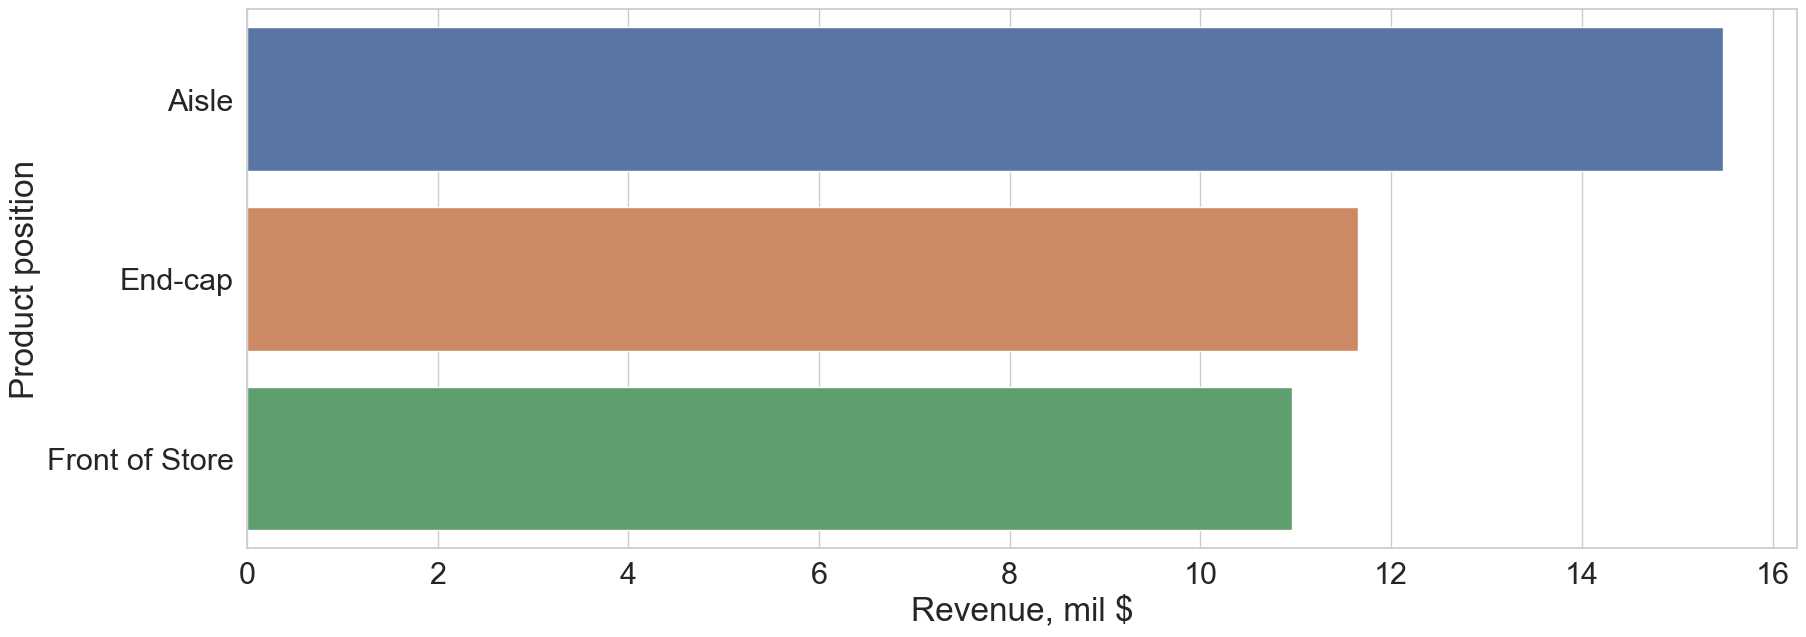

In [38]:
rev_by_prod_pos_df = sales.groupby('product_position', as_index=False).revenue_by_item.sum()

ax3_1 = sns.barplot(y = rev_by_prod_pos_df.product_position,
                    x = rev_by_prod_pos_df.revenue_by_item / 1000000)
ax3_1.set(xlabel='Revenue, mil $', ylabel='Product position')

# Распределение выручки по разным сегментам магазина

[Text(0.5, 0, 'Revenue, mil $'), Text(0, 0.5, 'Product position')]

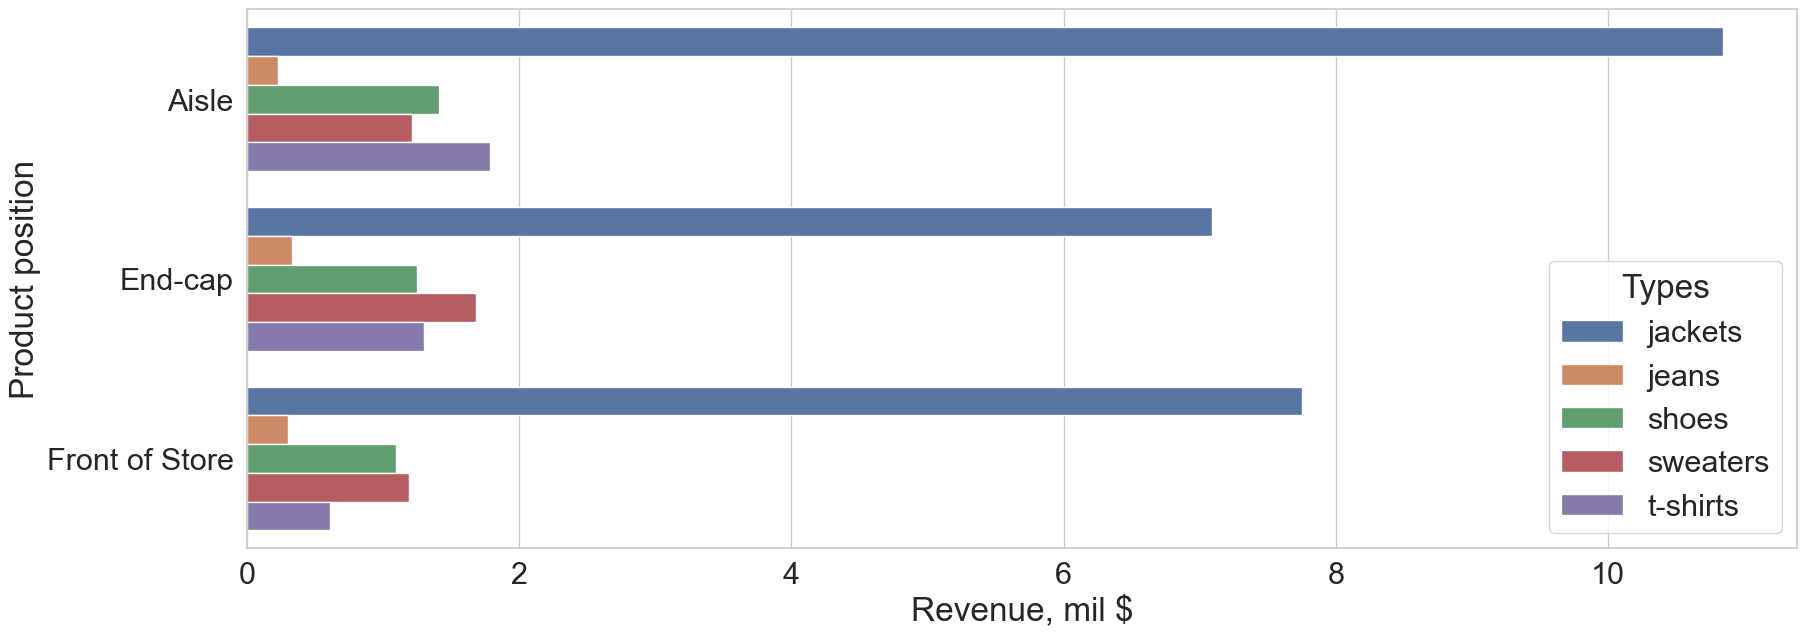

In [39]:
rev_by_prod_pos_w_terms_df =  sales.groupby(['product_position', 'terms'], as_index=False).revenue_by_item.sum()

# Строим датасет из sales с группировкой по типу товар, его местоположению в магазине и принесенной выручке

ax3_2 = sns.barplot(y   = rev_by_prod_pos_w_terms_df.product_position,
                    x   = rev_by_prod_pos_w_terms_df.revenue_by_item / 1000000,
                    hue = rev_by_prod_pos_w_terms_df.terms.rename('Types'))
ax3_2.set(xlabel='Revenue, mil $', ylabel='Product position')

# Распределение выручки по местонахождению товаров в магазине, в качестве подкатегорий использовались категории самих товаров:
# jackets, jeans, shoes, sweaters, t-shirts

# Слишком большой вклад вносит категория jackets, очевидный лидер. Представляет интерес посмотреть на отношение
# показателей остальных категорий без jackets.

[Text(0.5, 0, 'Revenue, mil $'), Text(0, 0.5, 'Product position')]

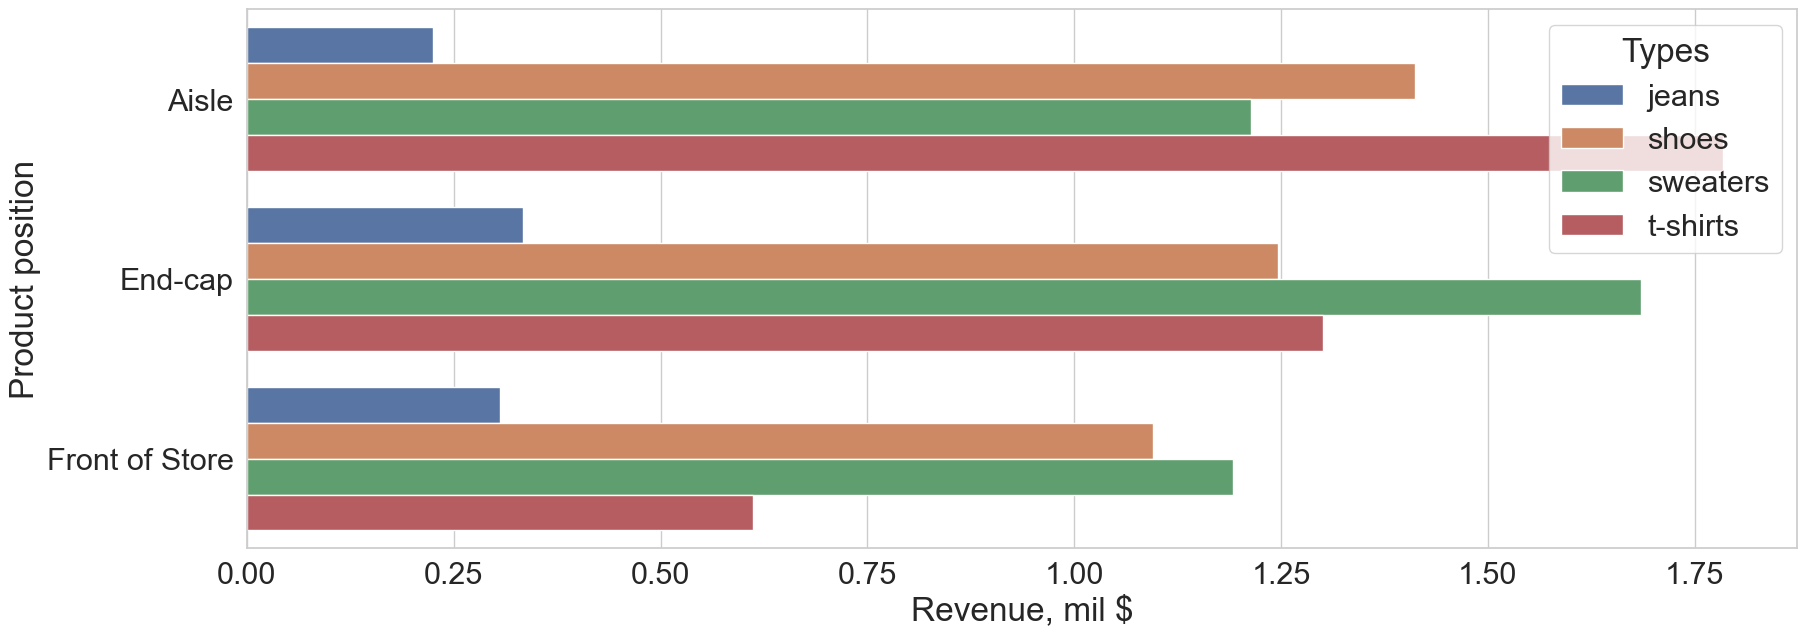

In [40]:
rev_by_prod_pos_w_terms_df_wo_jack = rev_by_prod_pos_w_terms_df \
                                .drop(rev_by_prod_pos_w_terms_df \
                                    .loc[rev_by_prod_pos_w_terms_df.terms == 'jackets'] \
                                    .index)

ax3_3 = sns.barplot(y   = rev_by_prod_pos_w_terms_df_wo_jack.product_position,
                    x   = rev_by_prod_pos_w_terms_df_wo_jack.revenue_by_item / 1000000,
                    hue = rev_by_prod_pos_w_terms_df_wo_jack.terms.rename('Types'))
ax3_3.set(xlabel='Revenue, mil $', ylabel='Product position')

# мы знаем, что shoes, sweaters, t-shirts приносят примерно одинаковую выручку, поэтому интересно как 
# местоположение в зале магазина влияет на выручку с каждой из этих категорий.
# Судя по полученным ниже зависимостям, в Aisle выгоднее всего выставлять t-shirts, 
# в End-cap - sweaters, а Front of store почти одинаково выгоден и для shoes, и sweaters.

<Axes: xlabel='sales_volume', ylabel='product_position'>

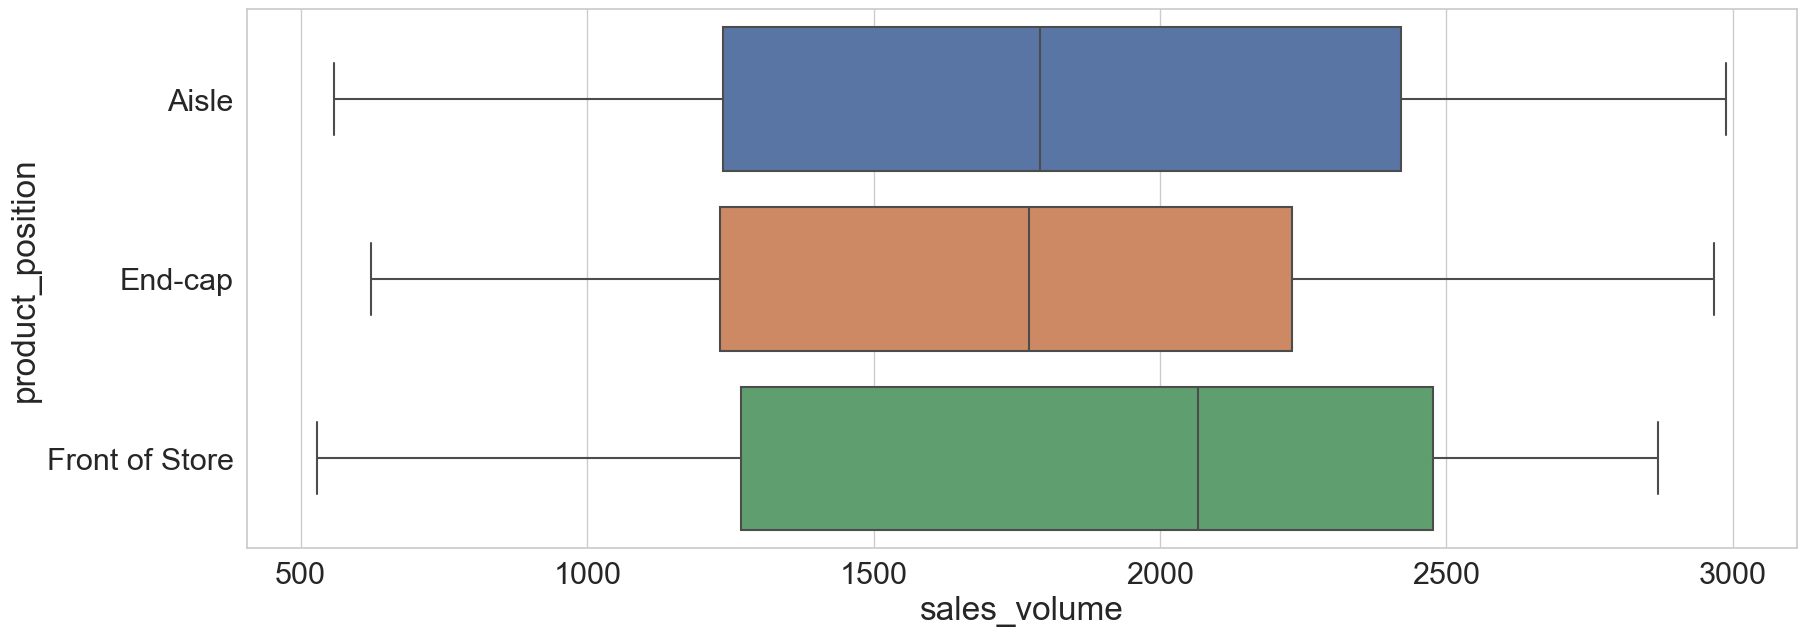

In [41]:
sns.boxplot(x = sales.sales_volume, y = sales.product_position)

<Axes: xlabel='sales_volume', ylabel='product_position'>

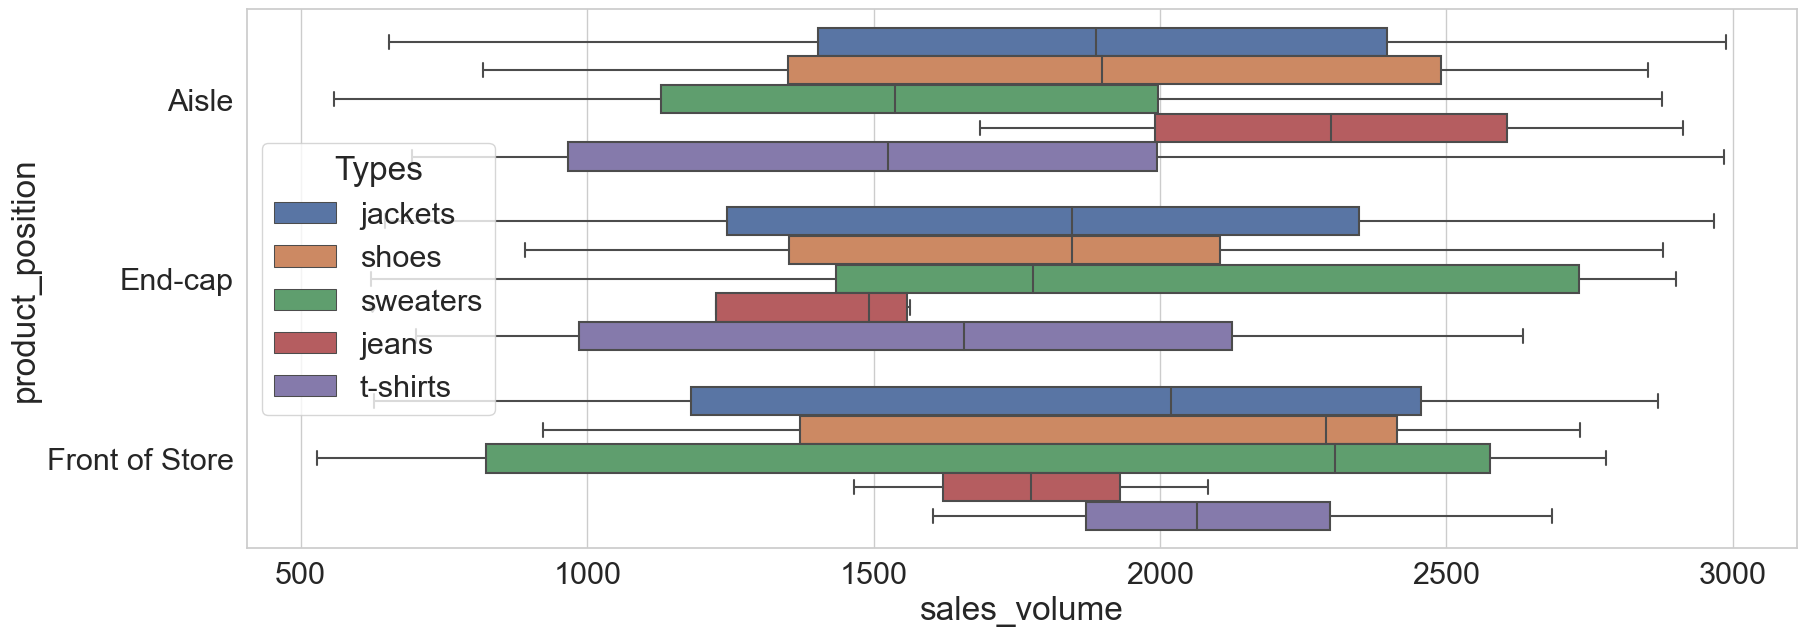

In [42]:
sns.boxplot(x = sales.sales_volume, 
            y = sales.product_position,
            hue = sales.terms.rename('Types'))

# Строим боксплот по количеству проданного товара в зависимости от его типа и местонахождения в магазине